# Analysing Different Methods of Finding $Q^2$ and $x$

## Finding $x$ and $Q^2$ using eletron scattering and the final hadronic state

In [12]:
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

s = 4 * 18 * 275
xe, xjb, xdiff, epz = [], [], [], []
Q2e, Q2jb = [],[]

# indexes of x we used
indexes = []

# get data from file
file_path = 'C:/Users/eholt/OneDrive/Documents/school/mentorship/EIC_JLAB_analysis/data/pythia8NCDIS_18x275_minQ2=10_beamEffects_xAngle=-0.025_hiDiv_1.0000.eicrecon.tree.edm4eic.root'
events = ur.open(file_path + ':events')
reconstructed_charged_particles = events['ReconstructedChargedParticles'].arrays()

# loop through events to find electrons and store their momentum
for i, event in  enumerate(reconstructed_charged_particles['ReconstructedChargedParticles.PDG']):
    eh, pzh, pyh, pxh, hadrons = 0, 0, 0, 0, 0
    
    xevent = []
    Q2event = []
    
    # if its just an electron, remove it
    if 1 == len(event):
        continue

    
    for j, particle in  enumerate(event):
        # if its an electron, find with scattered electron method
        if particle == 11:
            
            
            m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
            kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
            
            # check psuedo-rapidity
            kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
            theta = np.arccos(kp3/kp)
            pr = -np.log(np.tan(theta / 2))
            
            # remove particles with -4 < psuedo-rapidity < 4
            if abs(pr) < 4:
                
            
                kp0 = np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))

                k3 = -18
                m0 = 0.000511
                k0 = np.sqrt(m0**2 + k3**2)
                q0 = k0 - kp0
                q1 =    - kp1
                q2 =    - kp2
                q3 = k3 - kp3
                Q2 =-(q0**2 - q1**2 - q2**2 - q3**2) 
                Q2event.append(Q2)
                s = 4 * 10 *100 


                alpha = -0.025
                p1 = 275 * np.sin(alpha)
                p2 = 0
                p3 = 275 * np.cos(alpha)
                p0 = np.sqrt(0.938**2 + p1**2 + p2**2 + p3**2)
                pq = p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3
                xevent.append(0.5 * Q2 / pq)
                
                
        # get the sum of components from hadrons for JB method
        elif abs(particle) == 211 or abs(particle) == 321 or particle == 2212:
            
            
            m = reconstructed_charged_particles['ReconstructedChargedParticles.mass'][i][j]
            kp1, kp2, kp3 = reconstructed_charged_particles['ReconstructedChargedParticles.momentum.x'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.y'][i][j], reconstructed_charged_particles['ReconstructedChargedParticles.momentum.z'][i][j]
            
            
            kp = np.sqrt(kp1**2 + kp2**2 + kp3**2)
            theta = np.arccos(kp3/kp)
            pr = -np.log(np.tan(theta / 2))
            
            if abs(pr) < 4:
                hadrons += 1
                eh  += np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))
                pxh += kp1
                pyh += kp2
                pzh += kp3
            
    
    # add one per event
    y = 1/(2 * 18) * (eh - pzh)
    Q2 = 1/(1 - y) * (pxh**2 + pyh**2)
    
    if hadrons != 0:
        indexes.append(i)
        epz.append((eh - pzh))
        xjb.append(Q2 / (s * y))
        xe.append(xevent[Q2event.index(max(Q2event))])

        Q2jb.append(Q2)
        Q2e.append(max(Q2event))



## Finding the true $x$ and $Q^2$

In [20]:
mc_particles = events['MCParticles'].arrays()

Q2true, xtrue = [], []
# loop through all the indexes we got the other values from so we skip the same events
for i  in indexes:
    event = mc_particles['MCParticles.PDG'][i]
    Q2tot, xtot = [], []
    for j, particle in enumerate(event):
        if mc_particles['MCParticles.generatorStatus'][i][j] != 1 or particle != 11:
            continue
        
        psx, psy, psz = mc_particles['MCParticles.momentum.x'][i][j], mc_particles['MCParticles.momentum.y'][i][j], mc_particles['MCParticles.momentum.z'][i][j]
        E = 18
        Ep = np.sqrt(0.000511**2 + psx**2 + psy**2 + psz**2)
        theta = np.arctan2(np.sqrt(psx**2 + psy**2), psz)
        
        Q2 = 2 * E * Ep * (1 + np.cos(theta))
        
        y = 1 - 0.5 * Ep / E * (1 - np.cos(theta))
        s = 4 * 18 * 275
        x = Q2 / s / y
        xtot.append(x)
        Q2tot.append(Q2)

    # if we have multiple events, use one with largest Q2
    if len(xtot) > 0:
        xtrue.append(xtot[Q2tot.index(max(Q2tot))])
        Q2true.append(max(Q2tot))

print(len(xtrue))

553


## Comparing Methods for $x$

### Graphing $x_e$ vs $x_{JB}$

Text(0, 0.5, '$x_{JB}$')

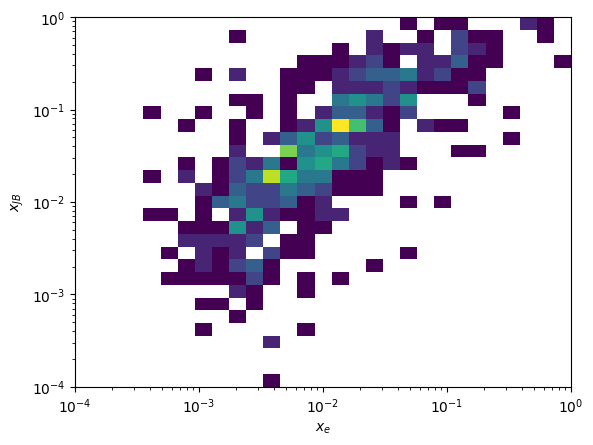

In [ ]:


x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

plt.hist2d(xe, xjb, bins = [x_bins, x_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x_e$')
plt.ylabel('$x_{JB}$')


### $x_{true}$ vs. $x_{JB}$ and $x_{e}$

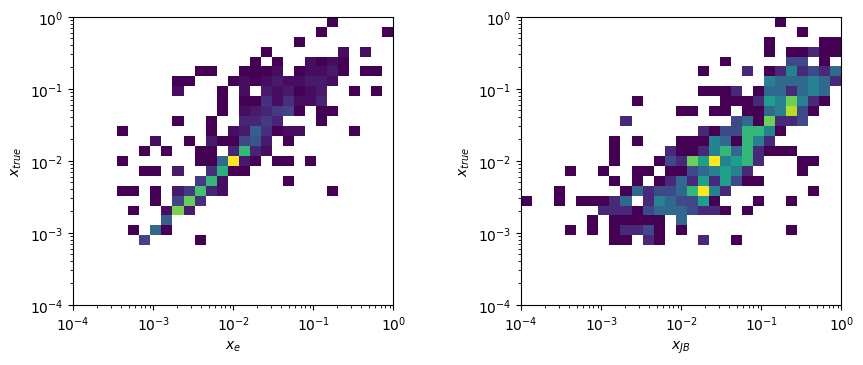

In [ ]:
x_bins = np.logspace(-4, 0, 30) # specify exponents of 10
Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10


fig2, hist2d =  plt.subplots(nrows=1, ncols=2)

hist2d[0].hist2d(xe, xtrue,  bins = [x_bins, x_bins],cmin = 1)
hist2d[0].set_xlabel("$x_e$")
hist2d[0].set_ylabel("$x_{true}$")
hist2d[0].set_yscale("log")
hist2d[0].set_xscale("log")


hist2d[1].hist2d(xjb, xtrue,  bins = [x_bins, x_bins],cmin = 1)
hist2d[1].set_xlabel("$x_{JB}$")
hist2d[1].set_ylabel("$x_{true}$")
hist2d[1].set_yscale("log")
hist2d[1].set_xscale("log")

plt.subplots_adjust(left=0.1, bottom=0.3, right=1.3, top=0.9, wspace=0.4, hspace=0.4)


## Comparing Different Methods for $Q^2$

### $Q^2_{true}$ vs. $Q^2_{JB}$ and $Q^2_{e}$

Text(0, 0.5, '$x_{JB}$')

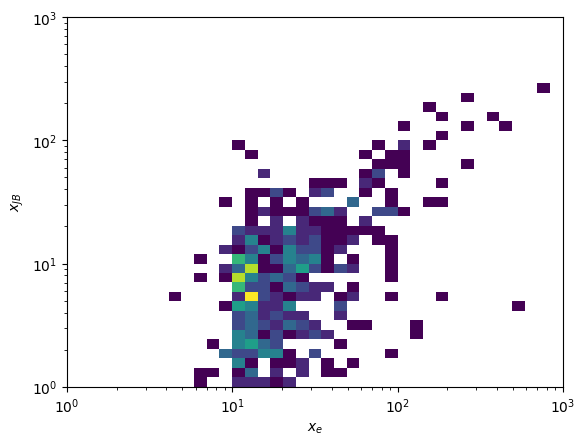

In [ ]:

Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10

plt.hist2d(Q2e, Q2jb, bins = [Q2_bins, Q2_bins],cmin = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$x_e$')
plt.ylabel('$x_{JB}$')

### $Q^2_{true}$ vs. $Q^2_{JB}$ and $Q^2_{e}$

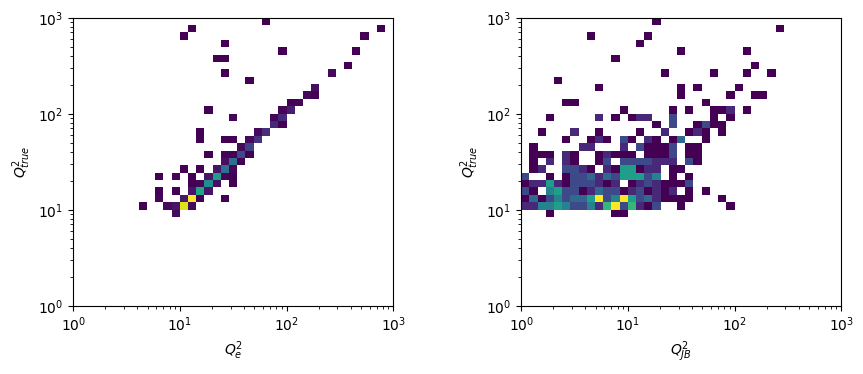

In [21]:

Q2_bins = np.logspace(0, 3, 40) # specify exponents of 10


fig2, hist2d =  plt.subplots(nrows=1, ncols=2)

hist2d[0].hist2d(Q2e, Q2true,  bins = [Q2_bins, Q2_bins],cmin = 1)
hist2d[0].set_xlabel("$Q^2_e$")
hist2d[0].set_ylabel("$Q^2_{true}$")
hist2d[0].set_yscale("log")
hist2d[0].set_xscale("log")


hist2d[1].hist2d(Q2jb, Q2true,  bins = [Q2_bins, Q2_bins],cmin = 1)
hist2d[1].set_xlabel("$Q^2_{JB}$")
hist2d[1].set_ylabel("$Q^2_{true}$")
hist2d[1].set_yscale("log")
hist2d[1].set_xscale("log")

plt.subplots_adjust(left=0.1, bottom=0.3, right=1.3, top=0.9, wspace=0.4, hspace=0.4)